# Question 1.1

In [820]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

In [821]:
df = pd.read_csv('./A1_co2.txt', sep=' ')
df.head()

,year,month,time,co2
0,1958,3,1958.208,315.71
1,1958,4,1958.292,317.45
2,1958,5,1958.375,317.50
3,1958,6,1958.458,317.10
4,1958,7,1958.542,315.86


> You should not use the observations for years 2018 and 2019 (Last 20 observations) for estimations/training - only for comparisons/testing.

In [822]:
# Let the train set be the measurements before 2018, and the test set be the measurements after 2018
train = df[df['year'] < 2018]
test = df[df['year'] >= 2018]

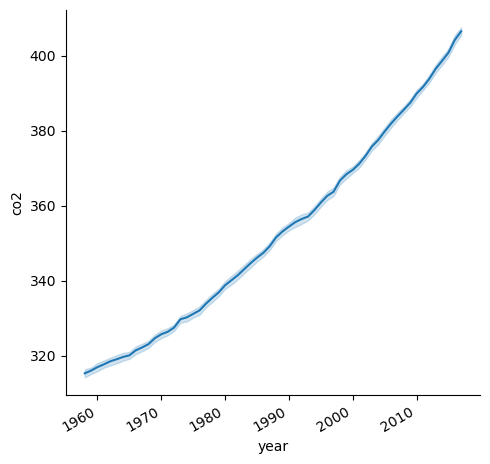

In [823]:
# TODO: Plot test and train set together

# Plot the train set
g = sns.relplot(x="year", y="co2", kind="line", data=train)
g.fig.autofmt_xdate()


# Question 1.2

## Question 1.2.1

In [824]:
MONTHS_IN_YEAR = 12

X = np.vstack(
    [
        np.ones_like(train.index),
        train.index,
        np.sin(2 * np.pi / MONTHS_IN_YEAR * train.index),
        np.cos(2 * np.pi / MONTHS_IN_YEAR * train.index),
    ]
).T

In [825]:
y = train["co2"].values

In [826]:
beta_hat, _, _, _ = np.linalg.lstsq(X, y)
beta_hat

/var/folders/p_/6wwjz4v11fs26vb5j8zwskgm0000gn/T/ipykernel_90460/2767225113.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  beta_hat, _, _, _ = np.linalg.lstsq(X, y)


array([3.06928362e+02, 1.28374044e-01, 1.69090265e+00, 2.25306869e+00])

## Question 1.2.2

In [827]:
N, p = X.shape

residuals = y - X @ beta_hat

sigma_hat2 = np.sum(residuals ** 2) / (N - p)
sigma_hat2

12.185026694430931

In [828]:
beta_hat_var = sigma_hat2 * np.linalg.inv(X.T @ X)
beta_hat_var

array([[ 6.77484239e-02, -1.41638461e-04, -4.00049374e-04,
        -2.70584607e-04],
       [-1.41638461e-04,  3.95086363e-07,  9.35333307e-07,
         9.35333307e-07],
       [-4.00049374e-04,  9.35333307e-07,  3.39442373e-02,
        -7.99112497e-05],
       [-2.70584607e-04,  9.35333307e-07, -7.99112497e-05,
         3.39442373e-02]])

/var/folders/p_/6wwjz4v11fs26vb5j8zwskgm0000gn/T/ipykernel_90460/985155053.py:2: RuntimeWarning: invalid value encountered in sqrt
  sns.heatmap(np.sqrt(beta_hat_var), annot=True, fmt=".2f")


<AxesSubplot: >

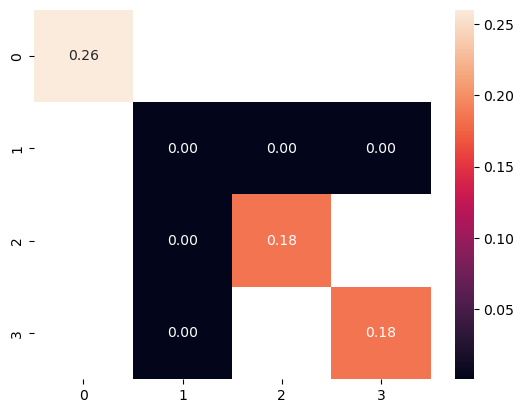

In [829]:
# Heatmap of the variance of the coefficients
sns.heatmap(np.sqrt(beta_hat_var), annot=True, fmt=".2f")

## Question 1.2.3

/var/folders/p_/6wwjz4v11fs26vb5j8zwskgm0000gn/T/ipykernel_90460/2672438754.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


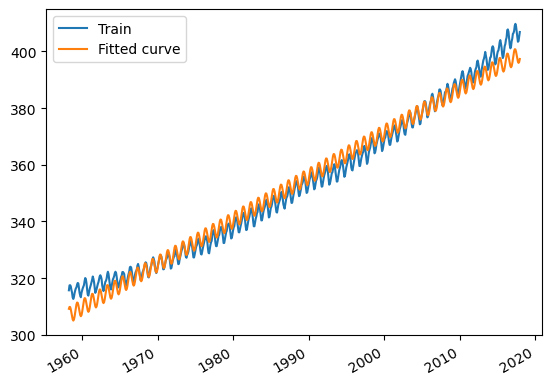

In [830]:
y_hat = X @ beta_hat

# Plot the train set and the fitted curve
fig, ax = plt.subplots()

ax.plot(train["time"], train["co2"], label="Train")
ax.plot(train["time"], y_hat, label="Fitted curve")

ax.legend()

fig.autofmt_xdate()
fig.show()

## Question 1.2.4

Plan-of-attack: Relaxtion algorithm

In [831]:
def rho_matrix(rho: float, n: int):
    """
    Returns the covariance matrix for the observations of a stationary AR(1) process.
    """
    rhos = np.vander([rho], n, increasing=True)
    return scipy.linalg.toeplitz(rhos)


N, p = X.shape

# Initial guess of correlation structure
Sigma = np.eye(N)

# Initial guess of coefficients
beta = beta_hat

betas = []

for _ in range(5):
    # E-step
    Sigma_inv = np.linalg.inv(Sigma)

    H = np.linalg.inv(X.T @ Sigma_inv @ X) @ X.T @ Sigma_inv

    beta_new = H @ y

    # M-step
    residuals = y - X @ beta_new

    rho = np.corrcoef(residuals[:-1], residuals[1:])[0, 1]
    
    Sigma_new = rho_matrix(rho, N)

    #if np.allclose(beta, beta_new, atol=1e-6) and np.allclose(Sigma, Sigma_new, atol=1e-6):
    #   break

    beta = beta_new
    Sigma = Sigma_new

    betas.append(beta)

beta

array([3.07470864e+02, 1.29839150e-01, 1.66890379e+00, 2.29457132e+00])

## Question 1.2.6

In [832]:
# Calculate the variance of the coefficients
sigma_hat2 = (residuals.T @ np.linalg.inv(Sigma) @ residuals ) / (N - p)

beta_var = np.linalg.inv(X.T @ np.linalg.inv(Sigma) @ X) * sigma_hat2
beta_var

array([[ 5.37440920e+00, -1.03811751e-02, -5.30015696e-04,
        -1.12349504e-03],
       [-1.03811751e-02,  2.89572528e-05,  2.30615165e-06,
         2.30615165e-06],
       [-5.30015696e-04,  2.30615165e-06,  4.57062027e-03,
         1.28481766e-05],
       [-1.12349504e-03,  2.30615165e-06,  1.28481766e-05,
         4.57062027e-03]])

/var/folders/p_/6wwjz4v11fs26vb5j8zwskgm0000gn/T/ipykernel_90460/3024580176.py:1: RuntimeWarning: invalid value encountered in sqrt
  sns.heatmap(np.sqrt(beta_var), annot=True, fmt=".2f")


<AxesSubplot: >

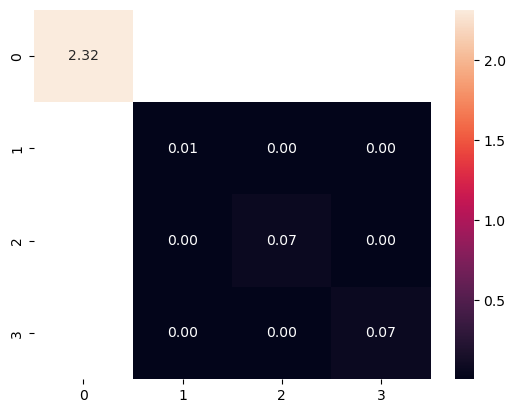

In [833]:
sns.heatmap(np.sqrt(beta_var), annot=True, fmt=".2f")

In [834]:
beta_hat - beta

array([-0.54250224, -0.00146511,  0.02199886, -0.04150264])

## Question 1.2.7

/var/folders/p_/6wwjz4v11fs26vb5j8zwskgm0000gn/T/ipykernel_90460/1449667870.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


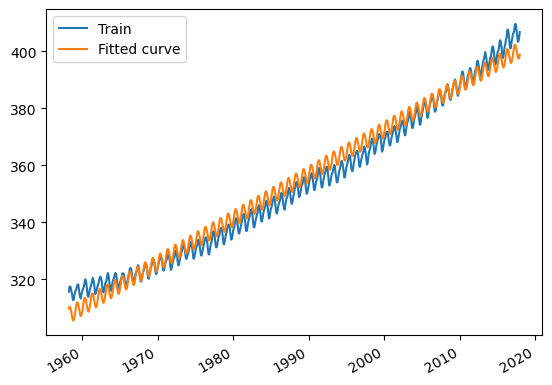

In [835]:
y_hat = X @ beta

# Plot the train set and the fitted curve
fig, ax = plt.subplots()

ax.plot(train["time"], train["co2"], label="Train")
ax.plot(train["time"], y_hat, label="Fitted curve")

ax.legend()

fig.autofmt_xdate()
fig.show()

# Question 1.3
## Question 1.3.1

See derivation on paper

## Question 1.3.2

Filter the data with the chosen model.

In [836]:
lambda_ = 0.9

In [837]:
def f(js):
    return np.vstack(
        [
            np.ones_like(js),
            js,
            np.sin(2 * np.pi / MONTHS_IN_YEAR * js),
            np.cos(2 * np.pi / MONTHS_IN_YEAR * js),
        ]
    )

In [838]:
L = np.array(
    [
        [1, 0, 0, 0],
        [1, 1, 0, 0],
        [0, 0, np.cos(2 * np.pi / MONTHS_IN_YEAR), np.sin(2 * np.pi / MONTHS_IN_YEAR)],
        [0, 0, -np.sin(2 * np.pi / MONTHS_IN_YEAR), np.cos(2 * np.pi / MONTHS_IN_YEAR)],
    ]
)

L_inv = np.linalg.inv(L)

In [839]:
N, p = X.shape

y_train = train["co2"].values
y_filtered = np.zeros_like(y_train)

f_0 = f(0)
f_1 = f(1)

BURN_IN = 10

# Initial filter parameters
F_i = np.zeros((p, p))
h_i = np.zeros((p, 1))
thetas = np.zeros((N, p))
sigmas = np.zeros(N)

y_pred = np.zeros(N)
scaled_residuals = np.zeros(N)
one_step_errors = np.zeros(N)

# Burn in
for i in range(BURN_IN):
    F_i = F_i + lambda_**i * f(-i) @ f(-i).T
    h_i = lambda_ * L_inv @ h_i + f_0 * y_train[i]

# Iterative filtering
for i in range(BURN_IN, N-1):
    # Update the filter parameters
    F_old = F_i
    F_i = F_i + lambda_**i * f(-i) @ f(-i).T

    h_i = lambda_ * L_inv @ h_i + f_0 * y_train[i]

    theta_i = np.linalg.inv(F_i) @ h_i

    thetas[i] = theta_i.flatten()

    # Filtered value
    y_filtered[i] = f_0.T @ theta_i
    y_pred[i] = f_1.T @ theta_i
    
    one_step_errors[i] = y_train[i+1] - y_pred[i]
    # Predictive variance
    scaled_residuals[i] = one_step_errors[i]**2 / (1 + f_1.T @ np.linalg.inv(F_i) @ f_1)

    sigmas[i] = np.sqrt(np.sum(scaled_residuals[BURN_IN:i]) / (i - BURN_IN))

/var/folders/p_/6wwjz4v11fs26vb5j8zwskgm0000gn/T/ipykernel_90460/2256850166.py:46: RuntimeWarning: invalid value encountered in double_scalars
  sigmas[i] = np.sqrt(np.sum(scaled_residuals[BURN_IN:i]) / (i - BURN_IN))


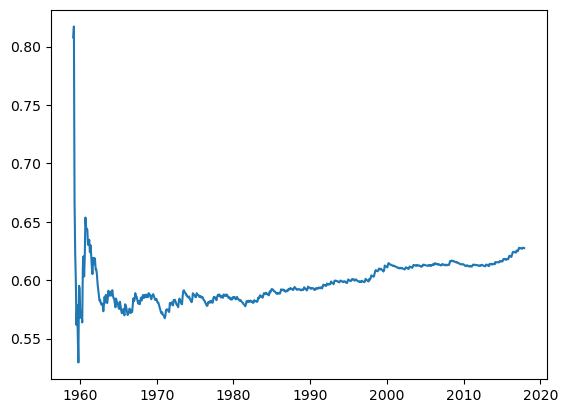

In [840]:
plt.plot(train["time"][BURN_IN+1:-1], sigmas[BURN_IN+1:-1], label="Residuals")

/var/folders/p_/6wwjz4v11fs26vb5j8zwskgm0000gn/T/ipykernel_90460/2274238649.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


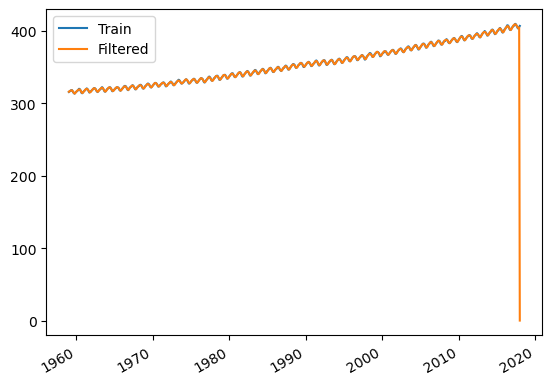

In [841]:
fig, ax = plt.subplots()

ax.plot(train["time"][BURN_IN:], train["co2"][BURN_IN:], label="Train")
ax.plot(train["time"][BURN_IN:], y_filtered[BURN_IN:], label="Filtered")
ax.legend()

fig.autofmt_xdate()
fig.show()

# Question 1.3.3

In [842]:
residuals = y_train[BURN_IN:] - y_filtered[BURN_IN:]


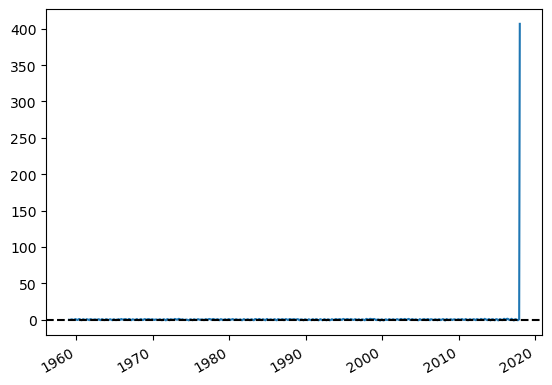

In [843]:
fig, ax = plt.subplots()

ax.plot(train["time"][BURN_IN:], residuals)
ax.axhline(0, color="black", linestyle="--")

fig.autofmt_xdate()


## Question 1.3.4

In [844]:
# Estimate the variance of the residuals
sigma_hat2 = np.sum(residuals ** 2) / (N - p)
sigma_hat2

232.03001978751686

In [845]:
sigma_hat = np.sqrt(sigma_hat2)
sigma_hat

15.232531627655229

In [846]:
import scipy.stats

ls = [1, 2, 6, 12, 24]

alpha = 0.05

y_hat = np.zeros(len(ls))
stds = np.zeros(len(ls))
lower_bound = np.zeros(len(ls))
upper_bound = np.zeros(len(ls))

# l-step prediction
for i, l in enumerate(ls):
    y_hat[i] = f(l).T @ theta_i

    var = sigma_hat2 * f(l).T @ np.linalg.inv(F_i) @ f(l) 

    stds[i] = np.sqrt(var)

    lower_bound[i] = y_hat[i] - scipy.stats.norm.ppf(1 - alpha) * np.sqrt(var)
    upper_bound[i] = y_hat[i] + scipy.stats.norm.ppf(1 - alpha) * np.sqrt(var)

In [847]:
predictions = pd.DataFrame(
    {
        "l": ls,
        "std": stds,
        "y_hat": y_hat,
        "lower_bound": lower_bound,
        "upper_bound": upper_bound,
    }
)

predictions

,l,std,y_hat,lower_bound,upper_bound
0,1,10.462234,406.069035,388.860193,423.277878
1,2,11.951733,407.935735,388.276883,427.594587
2,6,12.826285,411.749550,390.652188,432.846912
3,12,13.124765,407.250334,385.662017,428.838651
4,24,18.581144,409.841976,379.278714,440.405238
